# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [3]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [4]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

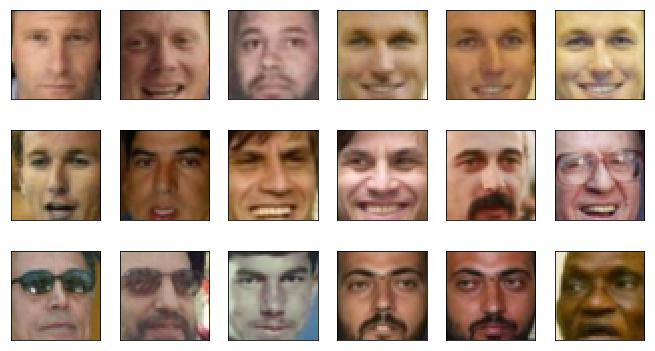

In [6]:
plot_gallery(X_train, image_h, image_w)

In [34]:
batch_size = 256

train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [86]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics


def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

class Autoencoder(nn.Module):
    def __init__(self, input_size=6075, hidden_size=1024):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, dimZ),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        initialize_weights(self)
        
    def forward(self, x):
        latent_code = self.encoder.forward(x)
        reconstruction =  self.decoder.forward(latent_code)
        
        return reconstruction, latent_code

In [87]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder()#.cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), 5e-4)

In [88]:
import time
from tqdm import tqdm_notebook as tqdm

def compute_loss(X_batch):
    X_var = Variable(X_batch)
    X_pred = autoencoder(X_var)[0]
    return criterion(X_pred, X_var)


train_loss = []
val_loss = []
num_epochs = 50

for epoch in range(num_epochs):
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    for X_batch, _ in train_loader:
        loss = compute_loss(X_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.data.numpy()[0])
        
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, _ in val_loader:
        loss = compute_loss(X_batch)
        val_loss.append(loss.data.numpy()[0])
    
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // batch_size :])))
    print("  val loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-len(val_loader) // batch_size :])))

Epoch 1 of 50 took 10.856s
  training loss (in-iteration): 	0.013734
  val loss (in-iteration): 	0.019890
Epoch 2 of 50 took 10.535s
  training loss (in-iteration): 	0.013062
  val loss (in-iteration): 	0.015049
Epoch 3 of 50 took 10.430s
  training loss (in-iteration): 	0.012549
  val loss (in-iteration): 	0.013500
Epoch 4 of 50 took 11.358s
  training loss (in-iteration): 	0.013003
  val loss (in-iteration): 	0.011949
Epoch 5 of 50 took 13.268s
  training loss (in-iteration): 	0.013846
  val loss (in-iteration): 	0.013063
Epoch 6 of 50 took 11.767s
  training loss (in-iteration): 	0.008182
  val loss (in-iteration): 	0.010435
Epoch 7 of 50 took 11.345s
  training loss (in-iteration): 	0.009174
  val loss (in-iteration): 	0.009801
Epoch 8 of 50 took 14.431s
  training loss (in-iteration): 	0.008840
  val loss (in-iteration): 	0.008993
Epoch 9 of 50 took 11.972s
  training loss (in-iteration): 	0.010311
  val loss (in-iteration): 	0.008952
Epoch 10 of 50 took 12.182s
  training loss (i

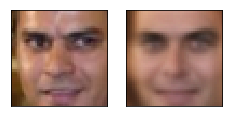

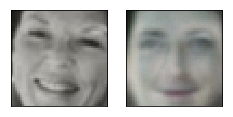

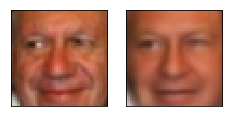

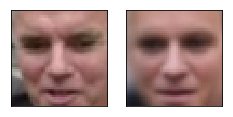

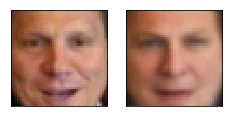

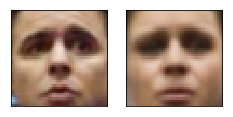

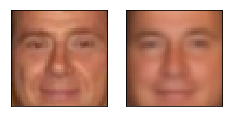

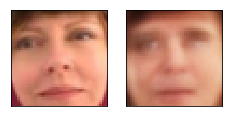

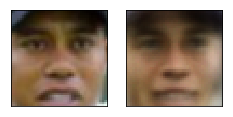

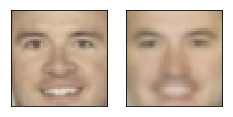

In [89]:
## Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    data = data[0][0], data[1]  # 1st example from the batch
    inp = Variable(data[0]) #.cuda()
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

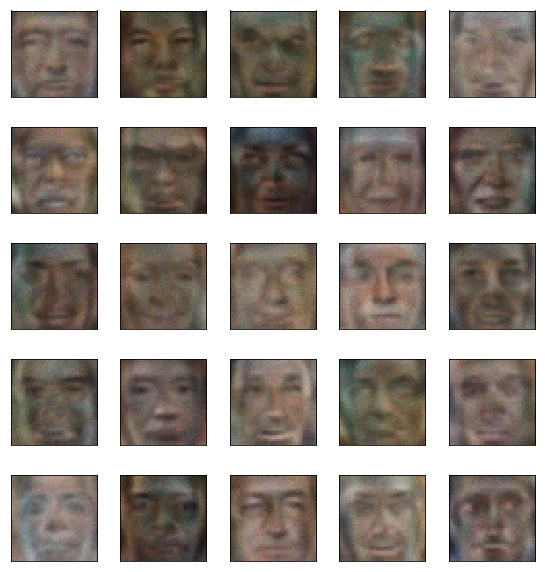

In [93]:
z = np.random.randn(25, dimZ) * 0.5
z = z.astype(np.float32)
output = autoencoder.decoder(Variable(torch.from_numpy(z))) # .cuda()
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [217]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 32

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self, input_size=6075, hidden_size=1024):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, dimZ)
        self.fc22 = nn.Linear(hidden_size, dimZ)
        self.fc3 = nn.Linear(dimZ, hidden_size)
        self.fc41 = nn.Linear(hidden_size, input_size)
        self.fc42 = nn.Linear(hidden_size, input_size)
        
        self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        initialize_weights(self)
        
        
    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.tanh(self.fc22(h1))

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.fc41(h3), self.tanh(self.fc42(h3))
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu, logsigma = self.encode(x.view(-1, 6075))
        z = self.gaussian_sampler(mu, logsigma)
        mu_rec, logsigma_rec = self.decode(z)
        # return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma
        return mu_rec, logsigma_rec, mu, logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [218]:
tmp = None
def KL_divergence(mu, logsigma):
#     global tmp
#     tmp = [mu.data.numpy(), logsigma.data.numpy(), mu.pow(2).data.numpy(), (2 * logsigma).exp().data.numpy()]
#     tmp += [(- mu.pow(2) - (2 * logsigma).exp()).data.numpy()]
    return -0.5 * torch.sum(2 * logsigma - mu.pow_(2) - (2 * logsigma).exp_())

def log_likelihood(x, mu, logsigma):
#     global tmp
#     tmp = [mu.data.numpy(), logsigma.data.numpy(), mu.pow(2).data.numpy(), (2 * logsigma).exp().data.numpy()]
#     tmp += [(- mu.pow(2) - (2 * logsigma).exp()).data.numpy()]
    return torch.sum( -0.5 * (mu - x.view(-1, 6075)).pow_(2) / (2 * logsigma).exp_() - logsigma)

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) - log_likelihood(x, mu_gen, logsigma_gen)

And train the model:

In [219]:
import time

vae = VAE()#.cuda()
optimizer = optim.Adam(vae.parameters(), 5e-4)

def compute_loss(X_batch):
    X_var = Variable(X_batch)
    mu_rec, logsigma_rec, mu, logsigma = vae(X_var)
    return loss_vae(X_var, mu_rec, logsigma_rec, mu, logsigma)


train_loss = []
val_loss = []
num_epochs = 50

for epoch in range(num_epochs):
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    for X_batch, _ in train_loader:
        loss = compute_loss(X_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.data.numpy()[0])
        
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, _ in val_loader:
        loss = compute_loss(X_batch)
        val_loss.append(loss.data.numpy()[0])
    
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // batch_size :])))
    print("  val loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-len(val_loader) // batch_size :])))

Epoch 1 of 50 took 27.023s
  training loss (in-iteration): 	-85671.578125
  val loss (in-iteration): 	-5088.206543
Epoch 2 of 50 took 27.425s
  training loss (in-iteration): 	-88979.648438
  val loss (in-iteration): 	-5558.858398
Epoch 3 of 50 took 27.181s
  training loss (in-iteration): 	-91435.570312
  val loss (in-iteration): 	-5699.557617
Epoch 4 of 50 took 25.980s
  training loss (in-iteration): 	-92074.421875
  val loss (in-iteration): 	-5692.074707
Epoch 5 of 50 took 26.325s
  training loss (in-iteration): 	-92145.484375
  val loss (in-iteration): 	-5725.311523
Epoch 6 of 50 took 26.325s
  training loss (in-iteration): 	-92361.554688
  val loss (in-iteration): 	-5771.226074
Epoch 7 of 50 took 28.288s
  training loss (in-iteration): 	-92019.164062
  val loss (in-iteration): 	-5781.502441
Epoch 8 of 50 took 28.050s
  training loss (in-iteration): 	-92836.734375
  val loss (in-iteration): 	-5788.888672
Epoch 9 of 50 took 30.456s
  training loss (in-iteration): 	-92777.312500
  val 

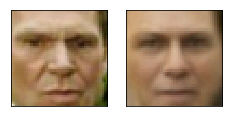

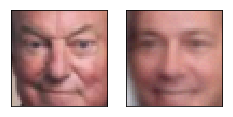

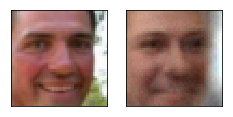

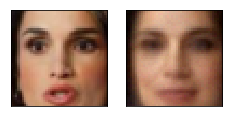

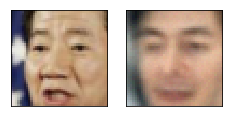

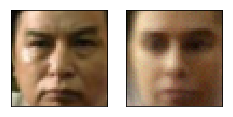

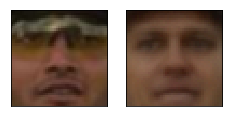

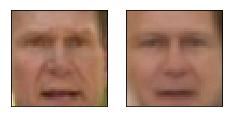

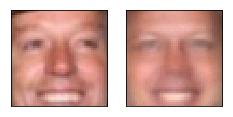

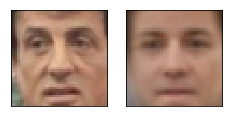

In [220]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    data = data[0][0], data[1]  # 1st example from the batch
    input = Variable(data[0]) # .cuda()
    reconstruction_mu, _, mu, _ = vae(input)
#     reconstruction_mu = np.clip(reconstruction_mu, 0, 1)
    plot_gallery([data[0].numpy(), np.clip(reconstruction_mu.data.cpu().numpy(), 0, 1)], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

In [216]:
np.sqrt(X_batch.numpy().shape[1] / 3)

45.0

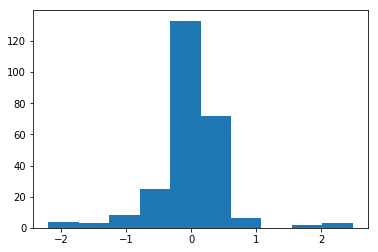

In [213]:
plt.hist(mu.data.numpy()[0]);

And finally sample from VAE.

In [ ]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z = np.random.randn(25, dimZ) * 1
z = z.astype(np.float32)
mu_rec, logsigma_rec = vae.decode(Variable(torch.FloatTensor(z)))
rec = np.random.normal(mu_rec.data.numpy(), logsigma_rec.exp().data.numpy())
# rec = np.random.normal(mu_rec.data.numpy(), logsigma_rec.data.numpy())
rec = np.clip(rec, 0, 1)
plot_gallery(rec, image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">